## Simulação de Monte Carlo

Nesse notebook é realizada a Simulção de Monte Carlo das emissões evitadas pela eletrificação da frota

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from utils.load_csv import load_csv
from utils.save_csv import save_csv

Dados requisição antiga

In [2]:
gdf = load_csv("gdf_final.csv")
df_diesel = gdf[gdf["is_eletrico"] == False].copy()

In [3]:
def sim_monte_carlo(df_diesel, Y, N=2000, dias=365):
    
    resultados_diarios = []

    for _ in range(N):
        amostra = df_diesel.sample(n=Y, replace=False)
        emissao_total = amostra["emissao_co2"].sum()
        resultados_diarios.append(emissao_total)

    resultados_diarios = np.array(resultados_diarios)
    resultados_acumulados = resultados_diarios * dias

    impacto_medio = resultados_diarios.mean()
    impacto_maximo = df_diesel.nlargest(Y, "emissao_co2")["emissao_co2"].sum()
    impacto_diferenca = impacto_maximo - impacto_medio

    IC_inf = np.percentile(resultados_diarios, 2.5)
    IC_sup = np.percentile(resultados_diarios, 97.5)

    return {
        "Y": Y,
        "dias": dias,
        "impacto_medio_dia": impacto_medio,
        "IC_inf_dia": IC_inf,
        "IC_sup_dia": IC_sup,
        "impacto_maximo_dia": impacto_maximo,
        "impacto_diferenca_dia": impacto_diferenca,
        "impacto_medio_acumulado": resultados_acumulados.mean(),
        "IC_inf_acumulado": np.percentile(resultados_acumulados, 2.5),
        "IC_sup_acumulado": np.percentile(resultados_acumulados, 97.5),
        "resultados_diarios": resultados_diarios,
        "resultados_acumulados": resultados_acumulados
    }

In [4]:
def estimar_frota_para_meta(
    df_diesel,
    meta_emissao,
    N=2000,
    Y_min=10,
    Y_max=500,
    passo=100
):

    resultados_meta = []

    for Y in range(Y_min, Y_max + 1, passo):
        sim = sim_monte_carlo(df_diesel, Y, N=N)

        valor = sim["impacto_medio_dia"]

        resultados_meta.append({
            "Y": Y,
            "impacto_estimado_medio": valor
        })

        if valor >= meta_emissao:
            break

    return pd.DataFrame(resultados_meta)

In [5]:
meta = 1  # t CO2 por dia

df_meta = estimar_frota_para_meta(
    df_diesel,
    meta_emissao=meta
)

display(df_meta.tail())

,Y,impacto_estimado_medio
0,10,0.001612
1,110,0.017711
2,210,0.034224
3,310,0.050369
4,410,0.067034


In [6]:
tamanhos_frota = [50, 100, 200]
dias_projecao = 365

res = [
    sim_monte_carlo(df_diesel, y, dias=dias_projecao)
    for y in tamanhos_frota
]

In [7]:
tabela_resumo = pd.DataFrame([
    {
        "Y": r["Y"],
        "Emissão média evitada (t CO2/dia)": r["impacto_medio_dia"],
        "IC95% inf (dia)": r["IC_inf_dia"],
        "IC95% sup (dia)": r["IC_sup_dia"],
        "Cenário máximo (t CO2/dia)": r["impacto_maximo_dia"],
        "Emissão média acumulada (t CO2)": r["impacto_medio_acumulado"]
    }
    for r in res
]).round(4)

display(tabela_resumo)

,Y,Emissão média evitada (t CO2/dia),IC95% inf (dia),IC95% sup (dia),Cenário máximo (t CO2/dia),Emissão média acumulada (t CO2)
0,50,0.0085,0.0039,0.0311,1.5803,3.0865
1,100,0.0165,0.0090,0.0417,2.6157,6.0153
2,200,0.0329,0.0204,0.0673,3.9396,12.0067


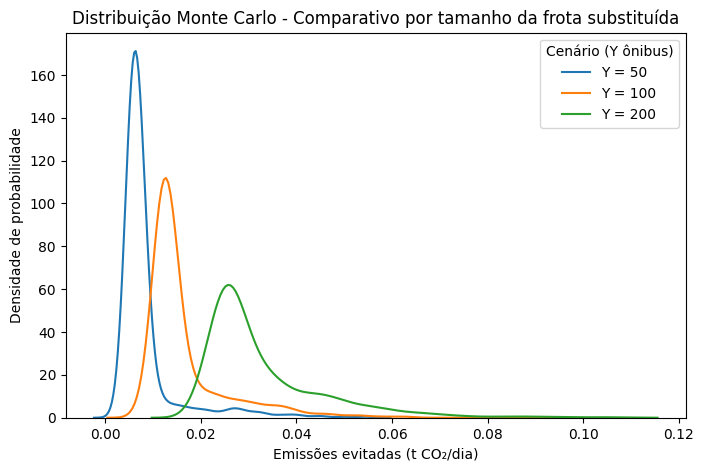

In [ ]:
plt.figure(figsize=(8,5))
for r in res:
    sns.kdeplot(
        r["resultados_diarios"],
        label=f"Y = {r['Y']}"
    )

plt.xlabel("Emissões evitadas (t CO₂/dia)")
plt.ylabel("Densidade de probabilidade")
plt.title("Distribuição Monte Carlo - Comparativo por tamanho da frota substituída")
plt.legend(title="Cenário (Y ônibus)")
plt.show()

Dados de teste do Dagster

In [7]:
df_posicoes_d1 = load_csv("calculo-distancia-percorrida_2025-10-20_silver.csv")
df_posicoes_d2 = load_csv("calculo-distancia-percorrida_2025-10-19_silver.csv")
df_posicoes_d3 = load_csv("calculo-distancia-percorrida_2025-10-17_silver.csv")

In [8]:
df_posicoes = pd.concat([df_posicoes_d1, df_posicoes_d2, df_posicoes_d3], ignore_index=True)

In [9]:
# aleatorização de modelos + ar condicionado
consumo_diesel = load_csv('consumo_diesel.csv')

tipos = consumo_diesel["tecnologia"].tolist()

mapa_modelo = {id_onibus: random.choice(tipos) for id_onibus in df_posicoes['codigo_onibus'].unique()}

df_posicoes['modelo'] = df_posicoes['codigo_onibus'].map(mapa_modelo)

df_posicoes = df_posicoes.merge(consumo_diesel, left_on="modelo", right_on="tecnologia", how="left")

np.random.seed(42)

df_posicoes["tem_ar"] = np.random.choice([True, False], size=len(df_posicoes))

In [10]:
# por codigo_onibus sum(distancia percorrida), pro onibus codigo_onibus x -> distancia_total=sum(distancia)
df_posicoes = (
    df_posicoes
    .groupby("codigo_onibus", as_index=False)
    .agg({
        "codigo_linha": "first",
        "nome_linha": "first",
        "letreiro": "first",
        "distancia_percorrida": "sum",
        "hora_requisicao": "first",
        "x": "first",
        "y": "first",
        "hora_gps": "last",
        "ponto_final": "last",
        "hora_final": "last",
        "segundos_deslocamento": "sum",
        "geometry": "first",
        "modelo": "first",
        "tem_ar": "first",
        'tecnologia': 'first',
        'sem_ar_l_km': 'first',
        'sem_ar_kg_km': 'first',
        'com_ar_l_km': 'first',
        'com_ar_kg_km': 'first' 
    })
)

In [11]:
# consumo -> distancia *modelos, #emissão -> consumo valor_emissao
def get_tipo_onibus(id_onibus):

    onibus = df_posicoes[df_posicoes['codigo_onibus']==id_onibus]

    return onibus['modelo'].unique()[0]


def get_fator_consumo(tipo_veiculo):

    cosumo_modelo = consumo_diesel[consumo_diesel['tecnologia']==tipo_veiculo]

    return cosumo_modelo['com_ar_l_km'].unique()[0]


def get_consumo_co2(row, km_rodados):

    fator_emissao_co2 = 2.671 

    consumo_l_km = row["com_ar_l_km"] if row["tem_ar"] else row["sem_ar_l_km"]

    emissao_co2 = km_rodados * consumo_l_km * fator_emissao_co2
    
    return emissao_co2


for i, row in df_posicoes.iterrows():
    if i < len(df_posicoes)-1:
        df_posicoes.loc[i, 'emissao_co2'] = get_consumo_co2(row, row['distancia_percorrida'])

df_posicoes["emissao_co2"] = df_posicoes["emissao_co2"] / 1000 # toneladas

In [12]:
def sim_monte_carlo(df_posicoes, Y, N=2000, seed=42):
    np.random.seed(seed)
    resultados = []

    for _ in range(N):
        amostra = df_posicoes.sample(n=Y, replace=False)
        emissao_total = amostra["emissao_co2"].sum()
        resultados.append(emissao_total)

    impacto_medio = np.mean(resultados)
    impacto_maximo = df_posicoes.nlargest(Y, "emissao_co2")["emissao_co2"].sum()
    impacto_diferenca = impacto_maximo - impacto_medio
    IC_inf = np.percentile(resultados, 2.5)
    IC_sup = np.percentile(resultados, 97.5)

    return {
        "Y": Y,
        "impacto_medio": impacto_medio,
        "IC_inf": IC_inf,
        "IC_sup": IC_sup,
        "impacto_maximo": impacto_maximo,
        "impacto_diferenca": impacto_diferenca,
        "resultados": resultados
    }

In [13]:
tamanhos_frota = [50, 100, 200]
res = [sim_monte_carlo(df_posicoes, y) for y in tamanhos_frota]

In [14]:
tabela_resumo = pd.DataFrame([
    {
        "Tamanho da frota substituída (Y)": r["Y"],
        "Emissão média evitada (t CO₂/no período)": r["impacto_medio"],
        "IC95% inferior": r["IC_inf"],
        "IC95% superior": r["IC_sup"],
        "Cenário máximo (t CO₂/no período)": r["impacto_maximo"],
        "Diferença (Máx - Média)": r["impacto_diferenca"]
    }
    for r in res
])

tabela_resumo = tabela_resumo.round(5)
tabela_resumo = tabela_resumo.sort_values(by="Tamanho da frota substituída (Y)")

print("\nResumo dos resultados da Simulação de Monte Carlo")
print("=" * 90)
display(tabela_resumo)


Resumo dos resultados da Simulação de Monte Carlo


,Tamanho da frota substituída (Y),Emissão média evitada (t CO₂/no período),IC95% inferior,IC95% superior,Cenário máximo (t CO₂/no período),Diferença (Máx - Média)
0,50,41776.49618,34969.89290,49507.63046,195116.79206,153340.29588
1,100,83469.22527,73588.23847,94356.09493,336962.53161,253493.30634
2,200,166799.59442,153026.56054,181108.50633,582140.63375,415341.03933


In [15]:
#plt.figure(figsize=(8,5))
#for r in res:
    #sns.kdeplot(r["resultados"], label=f"Y = {r['Y']}")
#plt.xlabel("Emissões evitadas (t CO₂/no período)")
#plt.ylabel("Densidade de probabilidade")
#plt.title("Distribuição Monte Carlo - Comparativo por tamanho da frota substituída")
#plt.legend(title="Cenário (Y ônibus)")
#plt.show()

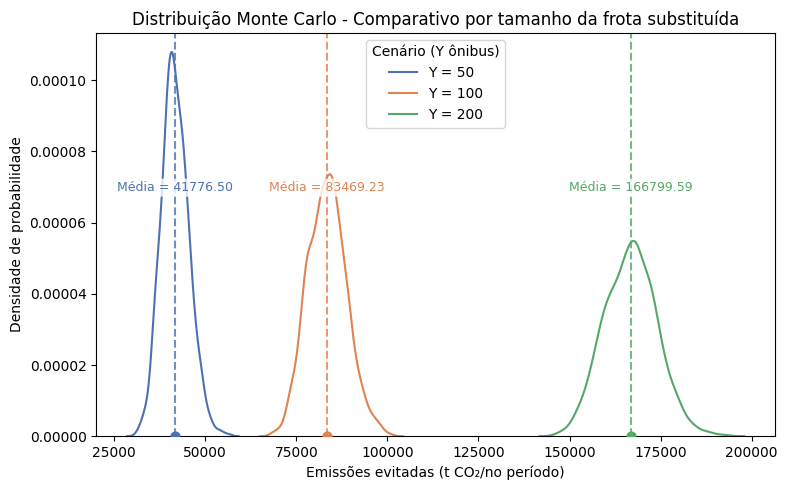

In [16]:
plt.figure(figsize=(8,5))

cores = sns.color_palette("deep", len(res))

for i, r in enumerate(res):
    sns.kdeplot(r["resultados"], label=f"Y = {r['Y']}", color=cores[i])
    
    media = np.mean(r["resultados"])
    
    plt.axvline(media, linestyle='--', color=cores[i], alpha=0.8)
    
    plt.scatter(media, 0, color=cores[i], s=40, zorder=5)
    
    plt.text(media, plt.ylim()[1]*0.6,  
             f"Média = {media:.2f}",  
             ha='center', va='bottom', color=cores[i],
             fontsize=9, rotation=0,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

plt.xlabel("Emissões evitadas (t CO₂/no período)")
plt.ylabel("Densidade de probabilidade")
plt.title("Distribuição Monte Carlo - Comparativo por tamanho da frota substituída")
plt.legend(title="Cenário (Y ônibus)")
plt.tight_layout()
plt.show()


In [17]:
df_posicoes["hora_gps"] = pd.to_datetime(df_posicoes["hora_gps"])

df_posicoes = df_posicoes.sort_values("hora_gps").reset_index(drop=True)

dias_unicos = df_posicoes["hora_gps"].dt.date.unique()
mapa_dias = {d: f"dia {i+1}" for i, d in enumerate(dias_unicos)}
df_posicoes["dia"] = df_posicoes["hora_gps"].dt.date.map(mapa_dias)

In [20]:
df_posicoes.head()

,codigo_onibus,codigo_linha,nome_linha,letreiro,distancia_percorrida,hora_requisicao,x,y,hora_gps,ponto_final,...,geometry,modelo,tem_ar,tecnologia,sem_ar_l_km,sem_ar_kg_km,com_ar_l_km,com_ar_kg_km,emissao_co2,dia
0,64460,1275,502J-10,METRÔ STA. CRUZ - EST. AUTÓDROMO,551676.457829,01:05:00,-46.664956,-23.651473,2025-10-16 07:51:59-03:00,POINT (327897.309123536 7377273.983900921),...,POINT (330186.275525424 7383369.34632951),Básico,True,Básico,0.46,0.386,0.53,0.445,780.969744,dia 1
1,68142,1114,5010-10,STO. AMARO - JABAQUARA,800797.130440,04:39:00,-46.637890,-23.665543,2025-10-16 15:08:23-03:00,POINT (333649.73408162367 7382168.18370829),...,POINT (332965.21254755673 7381843.143067529),Miniônibus,False,Miniônibus,0.30,0.252,0.35,0.294,641.678741,dia 1
2,68561,1131,546A-10,STO. AMARO - JD. APURÁ,292026.979699,05:34:00,-46.652948,-23.706168,2025-10-16 19:44:53-03:00,POINT (328605.302180435 7379399.982717363),...,POINT (331481.48688482423 7377326.642868567),Biarticulado,True,Biarticulado,0.80,0.672,0.90,0.756,702.003656,dia 1
3,36068,33685,2705-10,METRÔ ITAQUERA - JD. FANGANIELO,652920.227158,05:15:00,-46.471230,-23.542023,2025-10-16 21:14:20-03:00,POINT (354752.00643502007 7395590.769291737),...,POINT (349823.51237260085 7395706.19728605),Padron,True,Padron,0.55,0.462,0.63,0.529,1098.688454,dia 1
4,55426,1632,573T-10,METRÔ CARRÃO - TERM. SAPOPEMBA,695280.701842,00:00:00,-46.492484,-23.593240,2025-10-16 23:54:04-03:00,POINT (347692.9658429253 7389095.879344583),...,POINT (347712.74908368464 7390012.286509567),Padron,False,Padron,0.55,0.462,0.63,0.529,1021.402115,dia 1


In [21]:
df_posicoes["emissao_co2"].describe()

count    12841.000000
mean       833.213517
std        522.232670
min          0.000000
25%        475.125213
50%        724.509999
75%       1076.594709
max       9662.234316
Name: emissao_co2, dtype: float64

In [18]:
save_csv(df_posicoes, "df_posicoes_dagster.csv")

Base salva em data\df_posicoes_dagster.csv
